<center>
    <h1>
    Data Fromages.csv<br>
    </h1>
</center>

In [1]:
%%html

<!-- styles d'affichage -->
<style>
    .section_div {
        width:70%;
        height:1.5px;
        border:none;
        color:black;
        background-color:black;
        margin: auto;
        margin-top: 0px;
        margin-bottom: 0px;
    }

    .answer {
        color:blue;
    }

    .question {
        color:red;
    }

    .note {
        color:green;
        font-weight: bold;
    }
</style>

In [2]:
#
# assure le reload de src si modifications sont faite
#
%load_ext autoreload
%autoreload 2

In [3]:
#
# import utilitaires
#
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import StandardScaler

In [4]:
#
# import package develope pour le projet
#
import aihelpers.notebook as notebook
import aihelpers.unsupervised as ai
import aihelpers.unsupervised.association_rules as rules

In [5]:
# Les etapes
# 1. load data
# 2. afficher les types
# 2.1 enlever les duplicats
# 2.2 regarder pour valeurs manquantes - flusher si pas beaucoup, sinon remplacer par mediane/most frequent
# 3. Prendre les types numeriques
# 4. Regarder les distributions et transformer au besoin
# 5. Regarder outlier et decider ce qu'on fait avec
# 7. Regarder correlation avec heatmap (ou pairplot si on peut)
# 8. Regarder si on peut reduire la dimensionalite avec PCA

# 9. KMEANS
# 9.1 Trouver le # de cluster (2 metriques sur graphe)
# 9.2 Afficher clusters et regarder pour outliers - si ouliter les enlever et refaire a partir de 9.1
# 9.3 Une fois satisfait des clusters, montrer silhouette score et bss/tss pour voir si les clusters 
#     sont expliques

# 10. CAH
# 10.1 Faire CAH et afficher dendograme + diagramme de gain d'inertie
# 10.2 Determiner # de cluster a partir de 10.1 - 
# 10.3 Afficher clusters et regarder pour outliers - si ouliter les enlever et refaire a partir de 9.1
# 10.4 Une fois satisfait des clusters, montrer silhouette score et bss/tss pour voir si les clusters 
#      sont expliques

# 11. DBSCAN
# 11.1 Faire nearest neibhoors pour determiner epsilon
# 11.2 Faire DBSCAN - attention -1 veut dire outlier
# 11.3 Montrer silhouette score et bss/tss pour voir si les clusters sont expliques

# 12. Comparer KMeans, CAH, DBSCAN - les clusters devraient etre tres similaires

# 13. Inclure types qualitatifs, transformer pour AFDM et refaire tout a partir de l'etape 4
# 14. Transformer les types quantitatifs en qualitatifs, tranformer pour MCA et refaire tout a 
#     partir de l'etape 4

In [6]:
# load data
# inspection visuelle prealable du fichier montre:
#     - ; separe colonne
#     - , delimiteur numerique
#     - 2 dernieres colonnes sont vide
cheese_df = pd.read_csv("Fromages.csv", delimiter=";", decimal=",")

print("Fromages HEAD:", cheese_df.shape)
display(cheese_df.head())

print()
ai.show_types(cheese_df)

Fromages HEAD: (29, 12)


,Fromages,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium,Unnamed: 10,Unnamed: 11
0,CarreDelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20,NaN,NaN
1,Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27,NaN,NaN
2,Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41,NaN,NaN
3,Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27,NaN,NaN
4,Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20,NaN,NaN



Types


,Fromages,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium,Unnamed: 10,Unnamed: 11
Type,object,int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64


In [7]:
#
# eliminer 2 derniere colonnes
#
cheese_df.drop(cheese_df.columns[-2:], axis=1, inplace=True)

In [8]:
#
# valeur manquantes
#
na_indices = ai.show_na(cheese_df)

Valeur manquante 0 (0.0%)


<font class="answer">
Aucune valeur manquante observée.

In [9]:
#
# doublons
#
dup_indices = ai.show_duplicates(cheese_df)

Doublons 0 (0.0%)


<font class="answer">
Aucun doublon observé.

In [10]:
#
# separer quantitatif et qualitatif et afficher stats generales

data_quant_df = cheese_df.select_dtypes(exclude="object")
data_qual_df = cheese_df.select_dtypes(include="object")

print("Stats générales var. quantitatives")
display(data_quant_df.describe().round(3))

print()

print("Stats générales var. qualitatives")
display(data_qual_df.describe().round(3))

Stats générales var. quantitatives


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
count,29.000,29.000,29.000,29.000,29.000,29.000,29.000,29.000,29.000
mean,300.034,210.086,185.734,24.159,67.562,13.010,20.169,74.586,26.966
std,91.914,108.679,72.529,8.130,24.163,11.723,6.960,28.246,11.318
min,70.000,22.000,72.600,3.400,37.100,1.200,4.100,10.000,10.000
25%,292.000,140.000,132.900,23.400,51.600,4.900,17.800,70.000,20.000
50%,321.000,223.000,202.300,26.300,62.300,6.400,21.000,80.000,26.000
75%,355.000,276.000,220.500,29.100,76.400,21.100,23.400,90.000,30.000
max,406.000,432.000,334.600,33.300,150.500,36.400,35.700,120.000,51.000



Stats générales var. qualitatives


,Fromages
count,29
unique,29
top,CarreDelEst
freq,1


<font class="answer">
On note que Fromages semble plutôt un identifiant qu'une variable: 29 modalités. On le met en index. Les 9 autres variables sont de type quantitatives.

In [11]:
#
# mettre Fromages comme index
#
data_df = cheese_df.set_index("Fromages")

display(data_df.head())
print(data_df.shape)

,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
Fromages,,,,,,,,,
CarreDelEst,314,353.5,72.6,26.3,51.6,30.3,21.0,70,20
Babybel,314,238.0,209.8,25.1,63.7,6.4,22.6,70,27
Beaufort,401,112.0,259.4,33.3,54.9,1.2,26.6,120,41
Bleu,342,336.0,211.1,28.9,37.1,27.5,20.2,90,27
Camembert,264,314.0,215.9,19.5,103.0,36.4,23.4,60,20


(29, 9)


Distribution var. originales


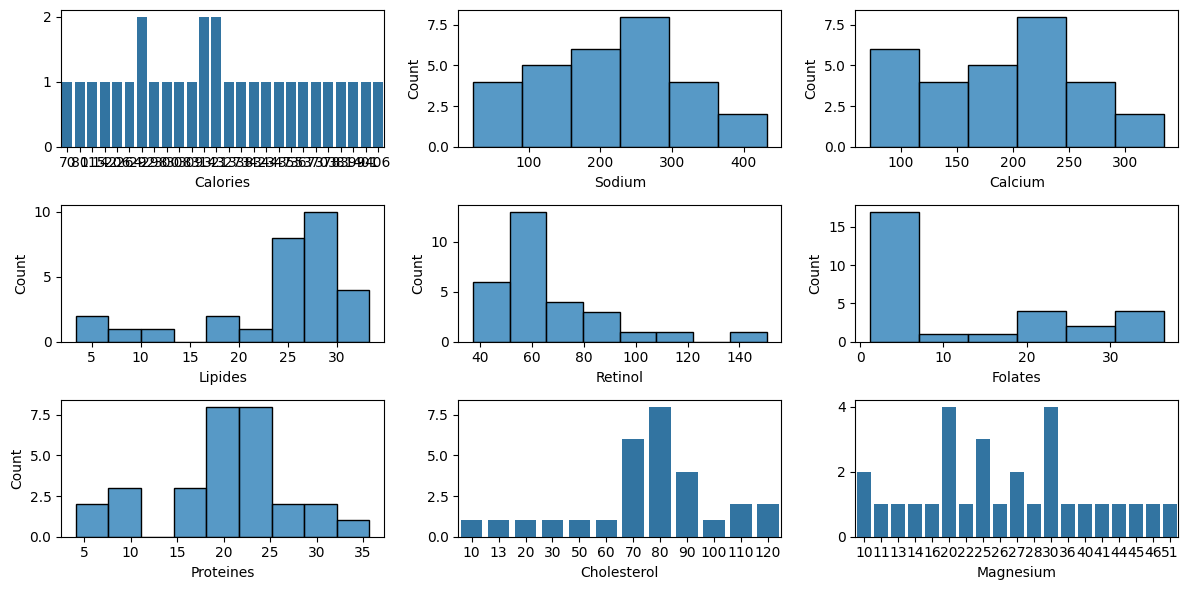

In [12]:
#
# examiner les distributions
#
print("Distribution var. originales")
ai.show_distributions(data_df, figsize=(12, 6), num_cols=3)

<font class="answer">
Les distributions ne sont pas gaussienne. On note aussi quelques outliers (détaillé plus loins dans le notebook). On note aussi une forte proportion près de 0 dans Folates. 

Outliers avec data original
IQR outliers par variable, eta: 1.5


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
Count,4.0,0.0,0.0,4.0,2.0,0.0,5.0,4.0,2.0
%,13.8,0.0,0.0,13.8,6.9,0.0,17.2,13.8,6.9



IQR outliers 8 (27.6%), eta: 1.5

Outliers boxplots, eta: 1.5


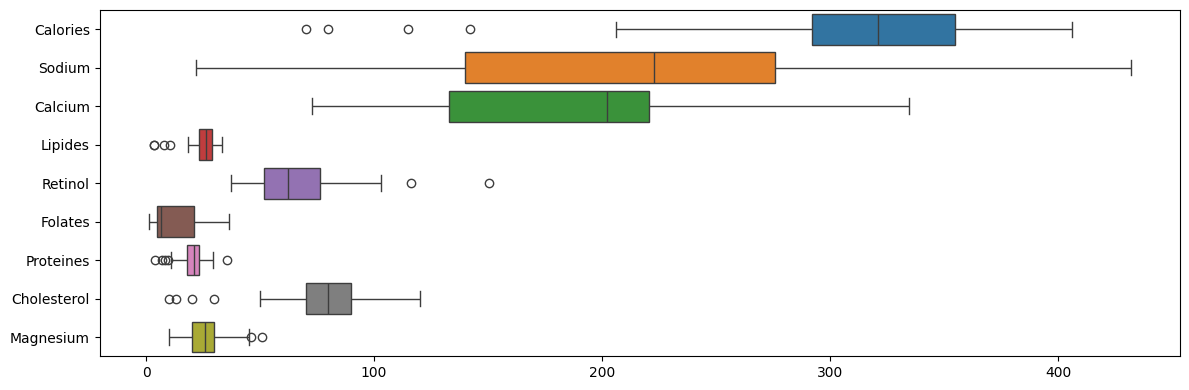

In [13]:
#
# examiner les outliers
#
print("Outliers avec data original")
outlier_indices = ai.show_outliers_iqr(data_df.copy(),
                                       eta=1.5,
                                       boxlists=[data_df.columns],
                                       figsize=(12, 4))

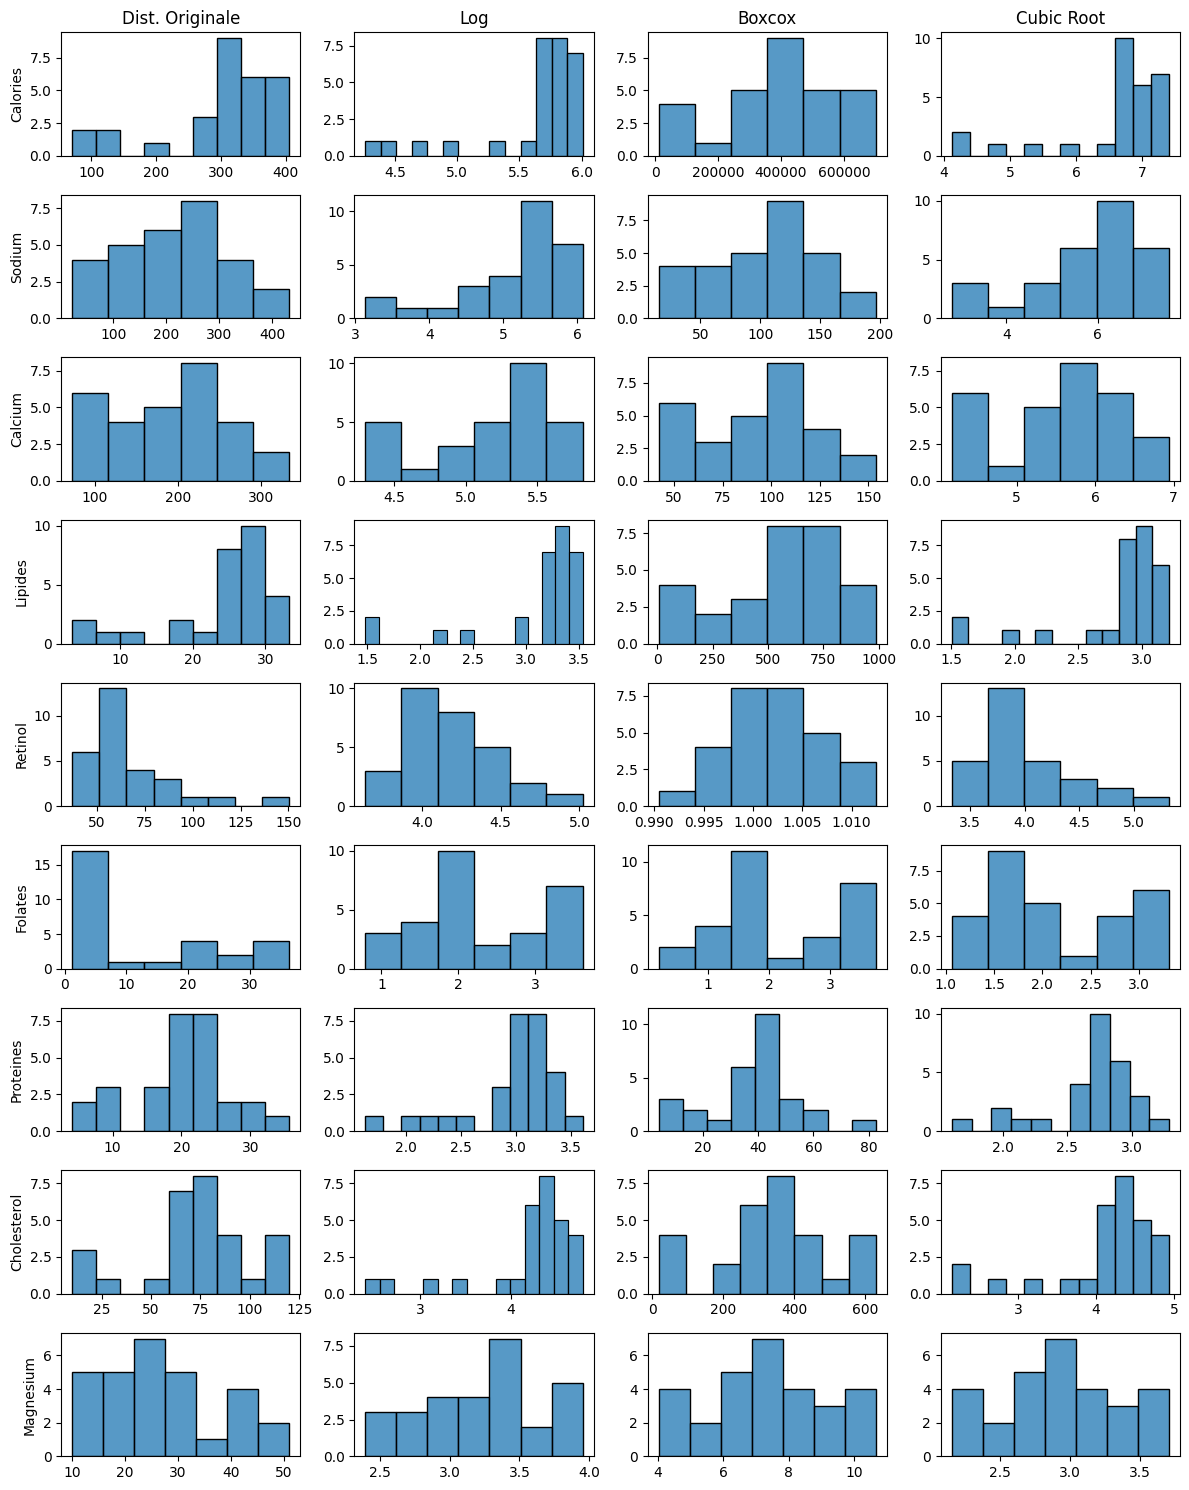

Boxcox lambdas
[np.float64(2.386), np.float64(0.8434), np.float64(0.837), np.float64(2.1908), np.float64(-0.9805), np.float64(0.0229), np.float64(1.3135), np.float64(1.4202), np.float64(0.4446)]


In [14]:
#
# transformer data pour voir effet sur outliers
#
data_transform = ai.show_transforms(data_df, figsize=(12, 15))
data_transformed_df, lambdas_ = data_transform.boxcox

print("Boxcox lambdas")
print([round(l, 4) for l in lambdas_])

<font class="answer">
Les distributions sont netment plus près d'une gaussienne sans toutefois être parfaite. Outliers semblent aussi un peu mieux.

Outliers avec data transformé
IQR outliers par variable, eta: 2.0


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
Count,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
%,0.0,0.0,0.0,0.0,0.0,0.0,3.4,6.9,0.0



IQR outliers 3 (10.3%), eta: 2.0

Outliers boxplots, eta: 2.0


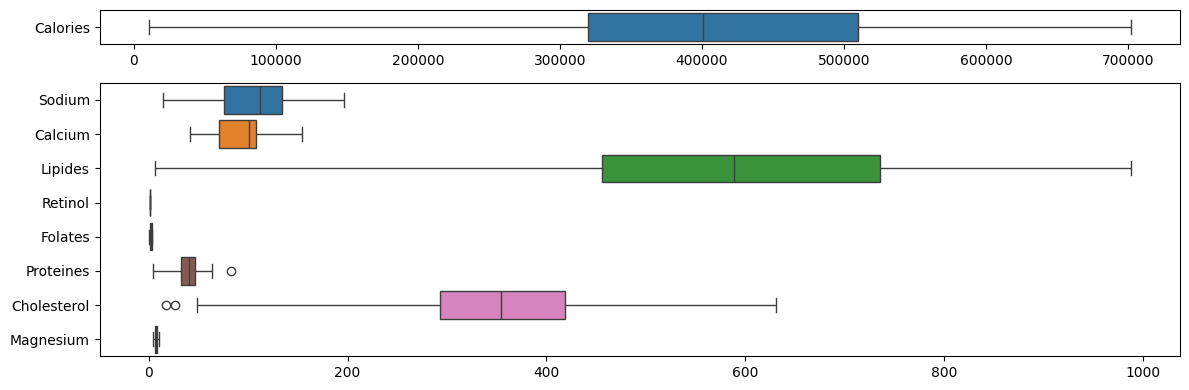

In [15]:
print("Outliers avec data transformé")
outlier_indices = ai.show_outliers_iqr(data_transformed_df, 
                                       eta=2.0,
                                       boxlists=[ [data_transformed_df.columns[0]],
                                                  data_transformed_df.columns[1:]],
                                       figsize=(12, 4))

<font class="answer">
Après avoir expérimenté avec eta, on voit qu'il y a netment moins d'outliers qu'à l'origine. On peut donc enlever ceux trouver du data transformé.

In [16]:
data_cleaned_df = data_transformed_df.drop(outlier_indices, axis=0)

print("Avant:", data_transformed_df.shape)
print("Après:", data_cleaned_df.shape)

Avant: (29, 9)
Après: (26, 9)


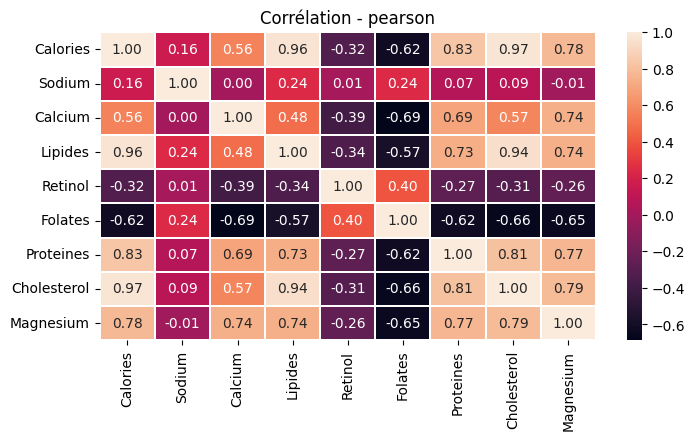

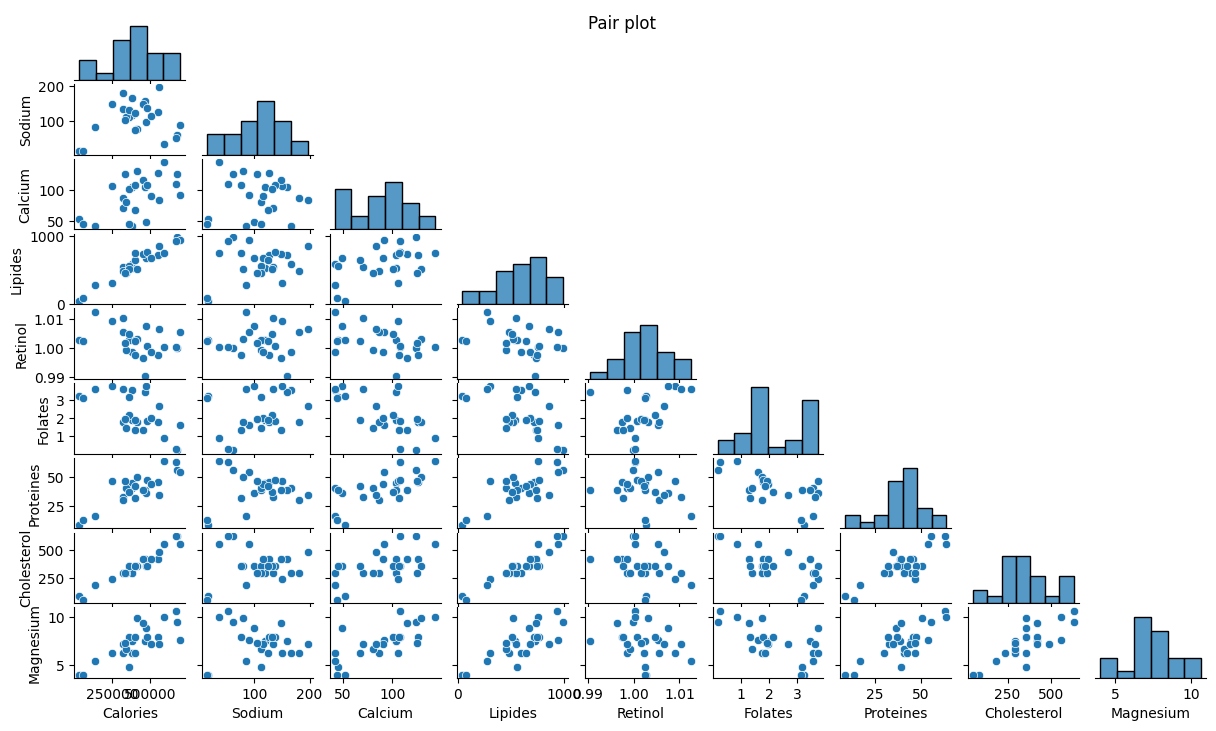

In [17]:
#
# examiner les correlations
#
ai.show_correlation(data_cleaned_df,
                    method="pearson",
                    figsize=(8, 4),
                    pairplot=True,
                    pairplot_figsize=(12, 7))

<font class="answer">
Il y a beaucoup de corrélation. ACP peut aider à diminuer le nombre de dimension.

Valeurs propres:
[5.7528 1.3103 0.9044 0.6419 0.3193 0.2445 0.1324 0.0371 0.0173]

Valeurs propres > 1:
[5.7528 1.3103]

Valeurs propres > 2.1314 (saporta):
[5.7528]

Variance expliquee %:
[61.5 14.   9.7  6.9  3.4  2.6  1.4  0.4  0.2]

Variance expliquee cumul. %:
[ 61.5  75.5  85.1  92.   95.4  98.   99.4  99.8 100. ]



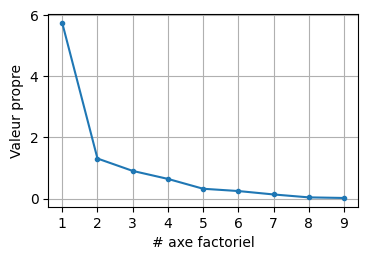

In [18]:
#
# centrer reduire data
#
doi = data_cleaned_df
data_std_df = StandardScaler().fit_transform(doi)
data_std_df = pd.DataFrame(data_std_df,
                           index=doi.index,
                           columns=doi.columns)

# reduction dimentionalite via ACP
ai.pca_analysis(data_std_df)

<font class="answer">
Coude franc à 2 axes factoriels et plus de 76% de variance expliquée. On garde 2 axes factoriels.

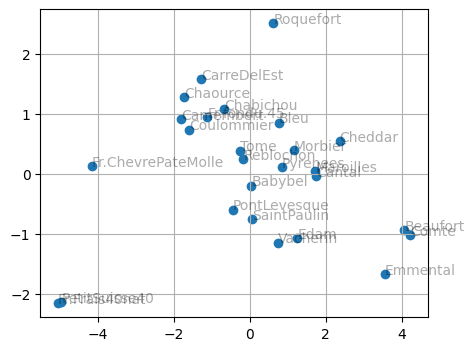

In [19]:
acp_ = ai.pca_init(data_std_df, 2)
acp_.mapping_row(1, 2)

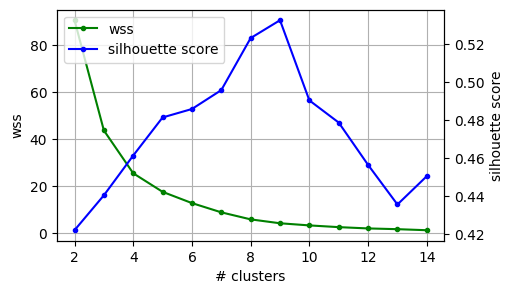

In [20]:
#
# cluster kmeans
#
ai.kmeans_analysis(acp_.row_coord_)

<font class="answer">
Le graphe nous indique 3 ou 5 clusters.

KMeans - 3 clusters
Davies Bouldin score: 0.7059

Silhouette score: 0.4405
Silhouette score par cluster
[np.float64(0.3477), np.float64(0.6242), np.float64(0.4696)]

Clusters means


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
0,0.818460,-0.354203,0.806657,0.770815,-0.490894,-0.896110,0.719930,0.798603,0.851839
1,-1.992493,-1.515071,-1.465145,-1.980983,0.783534,1.045042,-2.097484,-1.823654,-1.697104
2,-0.169779,0.622096,-0.282395,-0.135784,0.196796,0.448151,-0.069757,-0.193467,-0.263621



Variance expliquée par les clusters (triée par R2)


,Calories,Proteines,Lipides,Cholesterol,Magnesium,Calcium,Folates,Sodium,Retinol
$R^2$,0.73,0.709,0.691,0.648,0.646,0.538,0.535,0.507,0.183


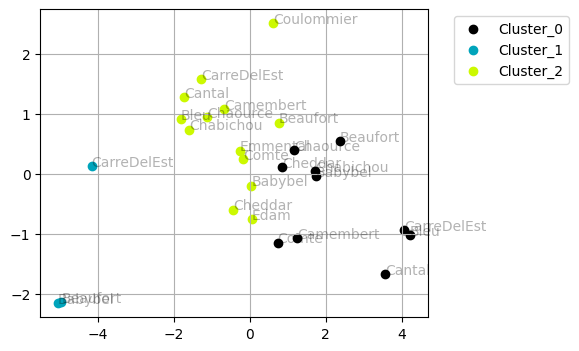

In [21]:
# essayons avec 3 clusters
kmeans_acp_3 = ai.kmeans_init(acp_.row_coord_, 3)

print("KMeans - 3 clusters")
ai.clusters_analysis(acp_.row_coord_[:, [0, 1]],
                     kmeans_acp_3.labels_,
                     data_std_df)
ai.show_clusters(acp_.row_coord_[:, [0, 1]],
                 acp_.row_labels_.to_numpy().astype("str"),
                 kmeans_acp_3.labels_,
                 text_alpha=0.3)

KMeans - 5 clusters
Davies Bouldin score: 0.6713

Silhouette score: 0.4815
Silhouette score par cluster
[np.float64(0.7966), np.float64(0.6763), np.float64(0.2616), np.float64(0.5545), np.float64(0.368)]

Clusters means


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
0,1.431416,-1.263508,1.173462,1.259965,-0.453785,-1.702533,1.591344,1.784073,1.586746
1,-0.351297,0.677737,-0.795259,-0.298262,0.724492,0.997958,-0.199007,-0.396797,-0.452989
2,0.734506,0.656735,0.415705,0.756766,-0.617243,-0.133736,0.244773,0.579196,0.269736
3,-1.992493,-1.515071,-1.465145,-1.980983,0.783534,1.045042,-2.097484,-1.823654,-1.697104
4,-0.192933,-0.046833,0.390953,-0.192105,-0.145071,-0.439875,0.142722,-0.222122,0.165836



Variance expliquée par les clusters (triée par R2)


,Cholesterol,Calories,Proteines,Lipides,Folates,Magnesium,Sodium,Calcium,Retinol
$R^2$,0.891,0.878,0.831,0.821,0.747,0.697,0.672,0.64,0.324


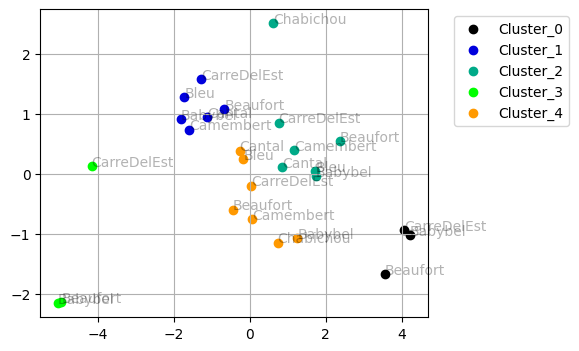

In [22]:
# essayons avec 5 clusters
kmeans_acp_5 = ai.kmeans_init(acp_.row_coord_, 5)

print("KMeans - 5 clusters")
ai.clusters_analysis(acp_.row_coord_[:, [0, 1]],
                     kmeans_acp_5.labels_,
                     data_std_df)
ai.show_clusters(acp_.row_coord_[:, [0, 1]],
                 acp_.row_labels_.to_numpy().astype("str"),
                 kmeans_acp_5.labels_,
                 text_alpha=0.3)

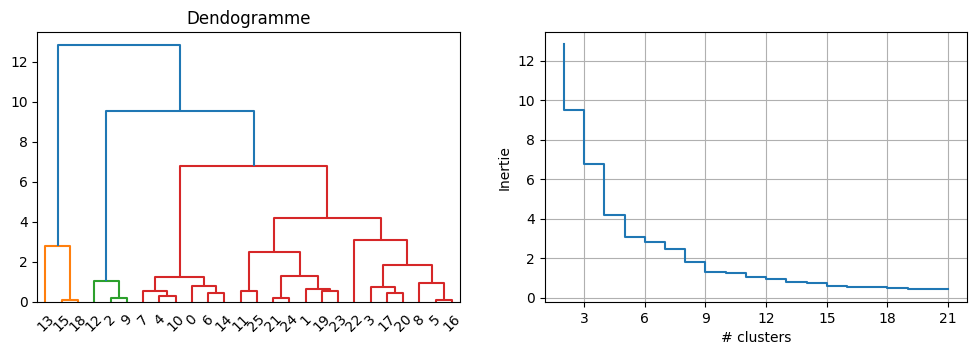

In [23]:
ai.cah_analysis(acp_.row_coord_)

<font class="answer">
On voit que 3 clusters semble être un coude.

CAH - 3 clusters
Davies Bouldin score: 0.4608

Silhouette score: 0.5245
Silhouette score par cluster
[np.float64(0.4549), np.float64(0.6704), np.float64(0.8422)]

Clusters means


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
0,0.084162,0.416787,0.043752,0.108153,-0.049462,0.098624,0.075921,0.005937,0.016554
1,-1.992493,-1.515071,-1.465145,-1.980983,0.783534,1.045042,-2.097484,-1.823654,-1.697104
2,1.431416,-1.263508,1.173462,1.259965,-0.453785,-1.702533,1.591344,1.784073,1.586746



Variance expliquée par les clusters (triée par R2)


,Proteines,Cholesterol,Calories,Lipides,Magnesium,Sodium,Folates,Calcium,Retinol
$R^2$,0.804,0.751,0.7,0.645,0.623,0.583,0.468,0.408,0.096


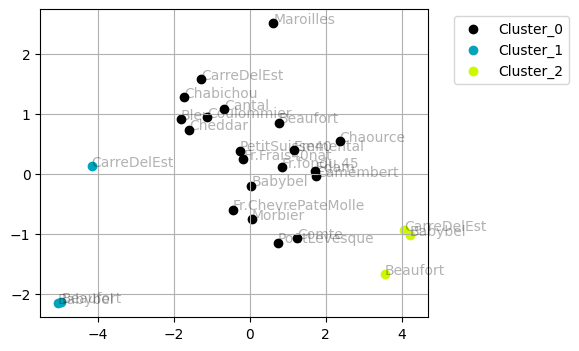

In [24]:
cah_acp_3 = ai.cah_init(acp_.row_coord_, 3)

print("CAH - 3 clusters")
ai.clusters_analysis(acp_.row_coord_[:, [0, 1]],
                     cah_acp_3.labels_,
                     data_std_df)
ai.show_clusters(acp_.row_coord_[:, [0, 1]],
                 acp_.row_labels_.to_numpy().astype("str"),
                 cah_acp_3.labels_,
                 text_alpha=0.3)

CAH - 4 clusters
Davies Bouldin score: 0.5362

Silhouette score: 0.474
Silhouette score par cluster
[np.float64(0.2802), np.float64(0.5545), np.float64(0.8127), np.float64(0.7163)]

Clusters means


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
0,0.270787,0.304951,0.403329,0.282330,-0.381157,-0.286806,0.193747,0.178537,0.217786
1,-1.992493,-1.515071,-1.465145,-1.980983,0.783534,1.045042,-2.097484,-1.823654,-1.697104
2,1.431416,-1.263508,1.173462,1.259965,-0.453785,-1.702533,1.591344,1.784073,1.586746
3,-0.351297,0.677737,-0.795259,-0.298262,0.724492,0.997958,-0.199007,-0.396797,-0.452989



Variance expliquée par les clusters (triée par R2)


,Proteines,Cholesterol,Calories,Folates,Lipides,Magnesium,Calcium,Sodium,Retinol
$R^2$,0.829,0.804,0.762,0.735,0.699,0.696,0.64,0.605,0.294


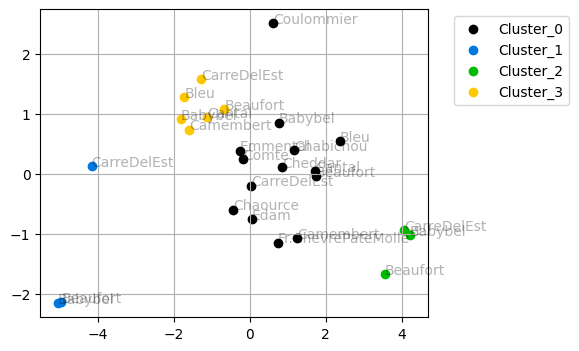

In [25]:
cah_acp_4 = ai.cah_init(acp_.row_coord_, 4)

print("CAH - 4 clusters")
ai.clusters_analysis(acp_.row_coord_[:, [0, 1]],
                     cah_acp_4.labels_,
                     data_std_df)
ai.show_clusters(acp_.row_coord_[:, [0, 1]],
                 acp_.row_labels_.to_numpy().astype("str"),
                 cah_acp_4.labels_,
                 text_alpha=0.3)

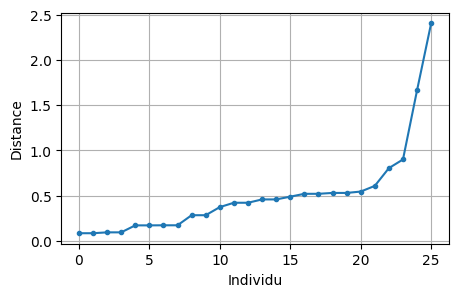

In [26]:
ai.dbscan_eps_analysis(acp_.row_coord_)

In [27]:
eps_opt, min_samples_opt = ai.dbscan_parameters_analysis(acp_.row_coord_,
                                                         np.arange(0.75, 1.5, 0.05),
                                                         range(2, 15))

DBSCAN optimal parameters
eps: 0.9500000000000002
min_samples: 3
silhouette score: 0.4414
# clusters: 2 + ouliers


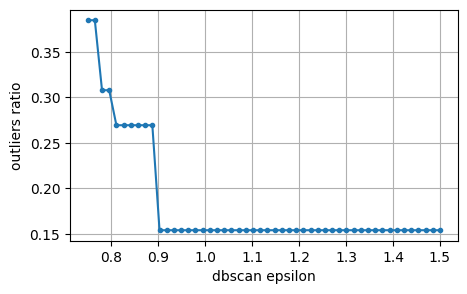

In [28]:
ai.dbscan_outliers_analysis(acp_.row_coord_,
                            np.linspace(0.75, 1.5, 50),
                            min_samples_opt)

DBS - 2 clusters
Davies Bouldin score: 0.8884

Silhouette score: 0.4414
Silhouette score par cluster
[np.float64(0.4463), np.float64(0.8406), np.float64(0.1186)]

Clusters means


,Calories,Sodium,Calcium,Lipides,Retinol,Folates,Proteines,Cholesterol,Magnesium
-1,-1.265942,-0.661588,-1.157097,-1.206527,0.822390,0.890931,-1.680092,-1.137274,-1.302525
0,0.040501,0.338783,0.058316,0.055064,-0.101484,0.081257,0.102439,-0.042270,0.023677
1,1.431416,-1.263508,1.173462,1.259965,-0.453785,-1.702533,1.591344,1.784073,1.586746



Variance expliquée par les clusters (triée par R2)


,Proteines,Cholesterol,Magnesium,Calories,Folates,Lipides,Calcium,Sodium,Retinol
$R^2$,0.734,0.568,0.552,0.484,0.461,0.409,0.367,0.335,0.135


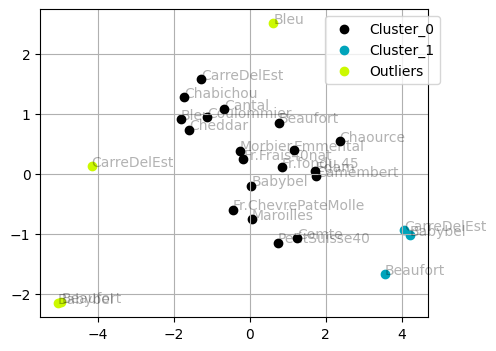

In [29]:
dbs_acp = ai.dbscan_init(acp_.row_coord_, eps_opt, min_samples_opt)

print("DBS - 2 clusters")
ai.clusters_analysis(acp_.row_coord_[:, [0, 1]],
                     dbs_acp.labels_,
                     data_std_df)
ai.show_clusters(acp_.row_coord_[:, [0, 1]],
                 acp_.row_labels_.to_numpy().astype("str"),
                 dbs_acp.labels_,
                 text_alpha=0.3)